**Lab11 Transfer learning and self - supervised learning**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/11_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/11_Transfer_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# 🛠️ Setup

In [1]:
# @title Install packages
%pip install -q --upgrade keras-cv
%pip install transformers datasets evaluate -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# @title Import packages
# Python ≥3.7 is recommended
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥1.01 is recommended
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Tensorflow ≥2.8.0 is recommended
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
import keras_cv
import keras

# Fintune CLIP, BERT, GPT
from transformers import pipeline
from transformers import AutoProcessor, TFAutoModelForZeroShotImageClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModelForCausalLM
from transformers import BertTokenizerFast, AutoModelForCausalLM
from transformers import TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import create_optimizer
from transformers.keras_callbacks import KerasMetricCallback
from transformers.keras_callbacks import PushToHubCallback
from datasets import load_dataset
import evaluate

print(tf.__version__, tf.keras.__version__, keras.__version__)

# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
import random
import time
import os
import shutil, pathlib
import PIL.Image as Image
import requests
import json
import urllib.request
from io import BytesIO

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

2.17.1 3.5.0 3.5.0


# 📘 Transfer learning on a small dataset

Here we will use the dataset that we have introduced in Lab 9.

## Downloading the data

The Dogs vs. Cats dataset that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](www.kaggle.com/c/dogs-vs-cats/data).

But you can also use Kaggle API. First, you need to create a Kaggle API key and download it to your local machine. Just navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

<p align="center">
<img src="https://drive.google.com/uc?id=1Yo0bW4A59Se1EbE50JZMiWNueErB2eJa" alt="drawing" width="600"/>
</p>

In [3]:
# @title Upload the API’s key JSON file to your Colab
# session by running the following code in a notebook cell:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# You can now download the data we’re about to use:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 812M/812M [00:41<00:00, 22.1MB/s]
100% 812M/812M [00:41<00:00, 20.7MB/s]


The first time you try to download the data, you may get a “403 Forbidden” error. That’s because you need to accept the terms associated with the dataset before you download it—you’ll have to go to www.kaggle.com/c/dogs-vs-cats/rules (while logged into your Kaggle account) and click the I Understand and Accept button. You only need to do this once.

In [4]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

We now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: **this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.**

## Data preprocessing



In [5]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Let’s look at the output of one of these Dataset objects: it yields batches of `180 × 180` RGB images (shape `(32, 180, 180, 3)`) and integer labels (shape `(32,)`). There are 32 samples in each batch (the batch size).

In [6]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Leveraging a pretrained model

A common and highly effective approach to deep learning on small image datasets is to use a pretrained model. A pretrained model is a model that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, the spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.2 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect it to perform well on the dogs-versus-cats classification problem. We’ll use the `VGG16` architecturetrained on ImageNet, to extract interesting features
from cat and dog images, and then train a dogs-versus-cats classifier on top of
these features. The `VGG16` model, among others, comes prepackaged with `tf.Keras`. You can import it from the [`tf.keras.applications`](https://keras.io/api/applications/) module.



In [7]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


We pass three arguments to the constructor:

* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don't need to include it.
* `input_shape` is the shape of the image tensors that we'll feed to the network. This argument is purely optional: if we don't pass it, the network will be able to process inputs of any size. Here we pass it so that we can visualize (in the following `summary`) how the size of the feature maps shrinks with each new convolution and pooling layer.

In [8]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

The final feature map has shape `(5, 5, 512)`. That's the feature map on top of which we'll stick a densely connected classifier. At this point, there are two ways we could proceed:

1. Run the convolutional base over our dataset, record its output to a `NumPy` array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, **this technique won't allow us to use data augmentation**.

2. Extend the model we have (`conv_base`) by adding `Dense` layers on top, and run the whole thing from end to end on the input data. This will allow us to use
data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first.

### Fast feature extration

We'll start by extracting features as `NumPy` arrays by calling the `predict()` method of the `conv_base` model on our training, validation, and testing datasets. **Let's iterate over our datasets to extract the `VGG16` features.**

In [9]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

📌 Importantly, `predict()` only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the `VGG16` model expects inputs that are **preprocessed with the function `tf.keras.applications.vgg16.preprocess_input`**, which scales pixel values to an appropriate range.

In [10]:
train_features.shape

(2000, 5, 5, 512)

### Defining and training the densely connected classifier

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

In [11]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# 1. Define the model
# Note the use of the Flatten layer before passing the
# features to a Dense layer.
inputs = tf.keras.Input(shape=(5, 5, 512))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# 2. Compile the model
model = tf.keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()


# 3. Train the model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8759 - loss: 19.3472 - val_accuracy: 0.9420 - val_loss: 9.4142
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9636 - loss: 4.3053 - val_accuracy: 0.9740 - val_loss: 4.2926
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 1.3065 - val_accuracy: 0.9620 - val_loss: 7.7719
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9772 - loss: 3.6755 - val_accuracy: 0.9700 - val_loss: 6.5505
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9879 - loss: 1.8735 - val_accuracy: 0.9800 - val_loss: 5.5280
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.2120 - val_accuracy: 0.9820 - val_loss: 4.4786
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.7263 - val_accuracy: 0.9700 - val_loss: 6.9782
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.4789 - val_accuracy: 0.9600 - val_los

Training is very fast because we only have to deal with two `Dense` layers. Let's look at the loss and accuracy curves during training

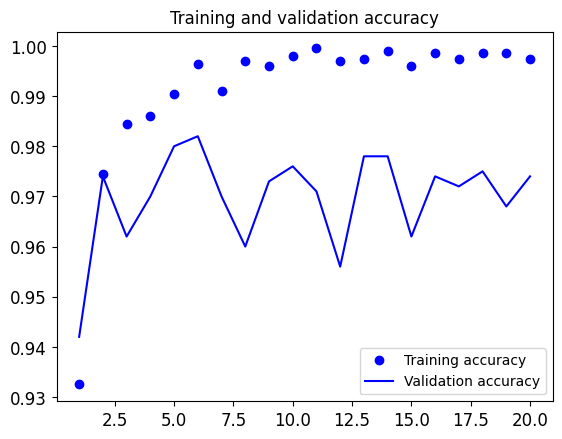

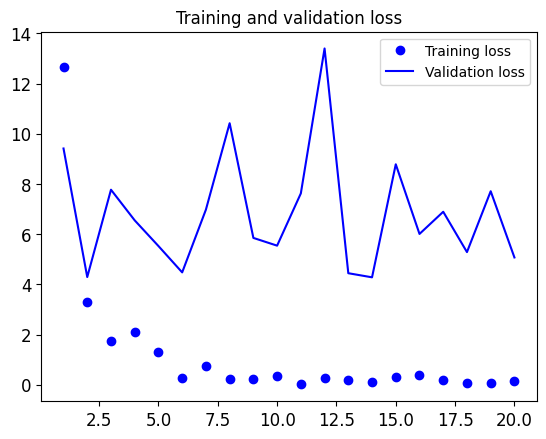

In [12]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy between 97%~98% — much better than we achieved in Lab 9 with the small model trained from scratch. This is a bit of an unfair
comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won't always be the case when you use pretrained features.

However, the plots also indicate that we're overfitting almost from the start—
despite using dropout with a fairly large rate. That's because this technique doesn't use data augmentation, which is essential for preventing overfitting with small image datasets.

## Feature extraction together with data augmentation

Now let’s review the second technique for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation
during training: creating a model that chains the `conv_base` with a new dense
classifier, and training it end to end on the inputs.

In order to do this, **we will first freeze the convolutional base**. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don’t do this, the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. In `tf.Keras`, we freeze a layer or model by setting its `trainable` attribute to `False`.

In [13]:
conv_base  = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [14]:
conv_base.trainable_weights

[<KerasVariable shape=(3, 3, 3, 64), dtype=float32, path=block1_conv1/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=block1_conv1/bias>,
 <KerasVariable shape=(3, 3, 64, 64), dtype=float32, path=block1_conv2/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=block1_conv2/bias>,
 <KerasVariable shape=(3, 3, 64, 128), dtype=float32, path=block2_conv1/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=block2_conv1/bias>,
 <KerasVariable shape=(3, 3, 128, 128), dtype=float32, path=block2_conv2/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=block2_conv2/bias>,
 <KerasVariable shape=(3, 3, 128, 256), dtype=float32, path=block3_conv1/kernel>,
 <KerasVariable shape=(256,), dtype=float32, path=block3_conv1/bias>,
 <KerasVariable shape=(3, 3, 256, 256), dtype=float32, path=block3_conv2/kernel>,
 <KerasVariable shape=(256,), dtype=float32, path=block3_conv2/bias>,
 <KerasVariable shape=(3, 3, 256, 256), dtype=float32, path=block3_conv3/kernel>,
 <KerasVariabl

In [15]:
conv_base.trainable = True
trainable_weights = conv_base.trainable_weights
total_trainable_weights = sum([tf.keras.backend.count_params(w) for w in trainable_weights])

print("This is the number of trainable weights "
      "before freezing the conv base:", total_trainable_weights)

This is the number of trainable weights before freezing the conv base: 14714688


In [16]:
conv_base.trainable = False
trainable_weights = conv_base.trainable_weights
total_trainable_weights = sum([tf.keras.backend.count_params(w) for w in trainable_weights])

print("This is the number of trainable weights "
      "after freezing the conv base:", total_trainable_weights)

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together which contains a data augmentation stage, our frozen convolutional base and a dense classifier.

In [17]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# Apply input value scaling.
x = tf.keras.applications.vgg16.preprocess_input(x)
x = conv_base(x) # Fix weight
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      3,277,056 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

With this setup, only the weights from the two `Dense` layers that we added will be trained. **That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector)**. Note that in order for these changes to take effect, you must first compile the model. **If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.**

Let’s train our model. Thanks to data augmentation, it will take much longer for
the model to start overfitting, so we can train for more epochs—let’s do 50.

In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.8391 - loss: 51.0002 - val_accuracy: 0.9390 - val_loss: 10.3863
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9315 - loss: 10.1354 - val_accuracy: 0.9780 - val_loss: 2.9522
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9554 - loss: 7.2321 - val_accuracy: 0.9350 - val_loss: 15.1025
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9518 - loss: 6.9389 - val_accuracy: 0.9770 - val_loss: 4.5277
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9592 - loss: 3.5615 - val_accuracy: 0.9770 - val_loss: 4.1804
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9606 - loss: 5.0087 - val_accuracy: 0.9750 - val_loss: 3.3192
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9754 - loss: 3.3654 - val_accuracy: 0.9780 - val_loss: 2.8050
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9632 - loss: 4.4179 - val_accuracy: 0.97

Let's plot the results again. As you can see, we reach a validation accuracy of about 98%. This is a strong improvement over the previous model.

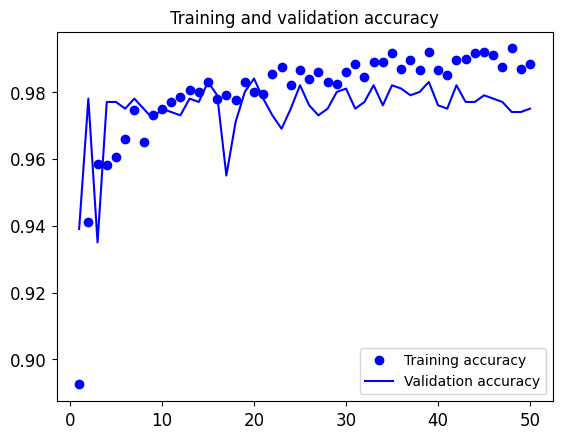

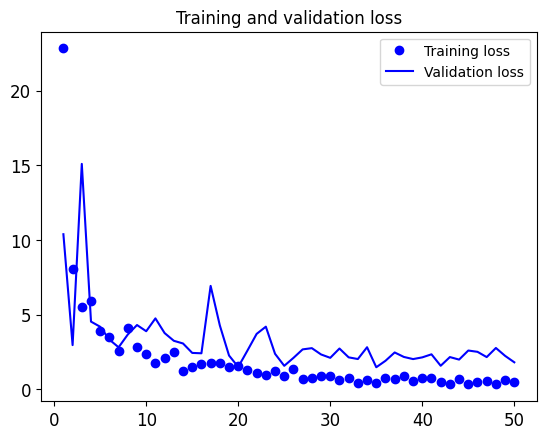

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [20]:
test_model = tf.keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9705 - loss: 3.2799
Test accuracy: 0.978


We get a test accuracy of 97.8%!

## Fine-tuning a pretrained model

We stated earlier that it's necessary to freeze the convolution base of `VGG16` in order to be able to train a randomly initialized classifier on top. For the
same reason, it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn't already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follows:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network. (Note that usually you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the lecture.)
5. Jointly train both these layers and the part we added.

You already completed the first three steps when doing feature extraction. Let's proceed with step 4: we'll unfreeze our `conv_base` and then freeze individual layers inside it.

In [21]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

We'll fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2`, and `block5_conv3` should be trainable.

In [22]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

📌 Now we can begin fine-tuning the model. We'll do this with the `RMSprop` optimizer, using a **very low learning rate**. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we're fine-tuning. Updates that are too large may harm these representations.

In [23]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.9879 - loss: 0.4882 - val_accuracy: 0.9760 - val_loss: 2.2309
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9885 - loss: 0.3358 - val_accuracy: 0.9810 - val_loss: 1.5071
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9901 - loss: 0.4351 - val_accuracy: 0.9770 - val_loss: 1.2675
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9927 - loss: 0.4024 - val_accuracy: 0.9820 - val_loss: 1.2066
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9906 - loss: 0.4132 - val_accuracy: 0.9810 - val_loss: 1.6107
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9898 - loss: 0.9344 - val_accuracy: 0.9760 - val_loss: 1.5501
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9933 - loss: 0.2439 - val_accuracy: 0.9810 - val_loss: 1.4448
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9901 - loss: 0.3534 - val_accuracy: 0.9800 -

In [24]:
model = tf.keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9797 - loss: 1.8593
Test accuracy: 0.979


Here, we get a test accuracy of 97.9%! By leveraging modern deep learning techniques, we managed to reach this result using only a small fraction of the training data that was available for the competition (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

# 📘 Using Keras Hub

[KerasCV](https://keras.io/keras_cv/) is a repository of pre-trained Keras vision models.

📌 Popular pretrained models are frequently becoming multi-modal. In the text domain, chat LLMs are adding support for image and audio inputs and outputs. In the vision domain, using text encoders is common for a wide range of tasks from image segmentation to image generation. To that end, we are consolidating KerasNLP and KerasCV into a KerasHub package. See https://github.com/keras-team/keras-hub/issues/1831.

## Inference with a pretrained classifier

Let's get started with the simplest KerasCV API: a pretrained classifier. In this example, we will construct a classifier that was pretrained on the ImageNet dataset. We'll use this model to solve the age old "Cat or Dog" problem.

The highest level module in KerasCV is a task. A task is a `keras.Model` consisting of a (generally pretrained) backbone model and task-specific layers. Here's an example using `keras_cv.models.ImageClassifier` with an `EfficientNetV2B0` Backbone. `EfficientNetV2B0` is a great starting model when constructing an image classification pipeline. This architecture manages to achieve high accuracy, while using a parameter count of 7M. If an `EfficientNetV2B0` is not powerful enough for the task you are hoping to solve, be sure to check out KerasCV's [other available Backbones](https://keras.io/api/keras_cv/models/)!

In [25]:
classifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

100%|██████████| 2.80k/2.80k [00:00<00:00, 2.57MB/s]


100%|██████████| 28.0M/28.0M [00:03<00:00, 9.05MB/s]


Now that our classifier is built, let's apply it to this cute cat picture!

45500/45500 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


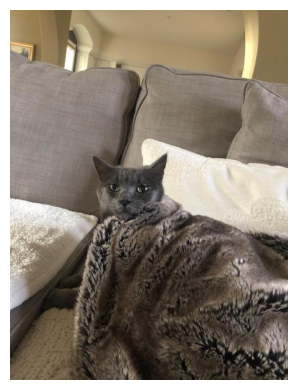

In [26]:
filepath = tf.keras.utils.get_file(origin="https://raw.githubusercontent.com/phonchi/nsysu-math608/refs/heads/main/static_files/cat.jpeg")
image = tf.keras.utils.load_img(filepath)
image = np.array(image)
keras_cv.visualization.plot_image_gallery(
    np.array([image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

Next, let's get some predictions from our classifier:

In [27]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


Predictions come in the form of softmax-ed category rankings. We can find the index of the top classes using a simple `argsort()` function:

In [28]:
top_classes = predictions[0].argsort(axis=-1)

In order to decode the class mappings, we can construct a mapping from category indices to ImageNet class names. For convenience, We've stored the ImageNet class mapping in a GitHub gist. Let's download and load it now.

In [29]:
classes = tf.keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)

33567/33567 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top two classes are: ['Egyptian cat', 'velvet']


Great! Both of these appear to be correct! However, one of the classes is "Velvet". We're trying to classify Cats VS Dogs. We don't care about the velvet blanket!

Ideally, we'd have a classifier that only performs computation to determine if an image is a cat or a dog, and has all of its resources dedicated to this task. This can be solved by fine tuning our own classifier.

## Transfer learning

When labeled images specific to our task are available, fine-tuning a custom classifier can improve performance. If we want to train a Cats vs Dogs Classifier, using explicitly labeled Cat vs Dog data should perform better than the generic classifier! For many tasks, no relevant pretrained model will be available (e.g., categorizing images specific to your application). We wiil use a larger dataset from [tfds](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs).

First, let's get started by loading some data:

In [30]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

Output hidden; open in https://colab.research.google.com to view.

In [32]:
dataset_info.splits["train"].num_examples

23262

Next let's construct our model. The use of imagenet in the preset name indicates that the backbone was pretrained on the ImageNet dataset. Pretrained backbones extract more information from our labeled examples by leveraging patterns extracted from potentially much larger datasets.

Next lets put together our classifier:

In [33]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

100%|██████████| 1.79k/1.79k [00:00<00:00, 2.30MB/s]


100%|██████████| 23.1M/23.1M [00:02<00:00, 8.25MB/s]


In [34]:
model.summary()

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, None, None, 1280)    │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,921,874 (22.59 MB)

 Trainable params: 5,861,266 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

Here our classifier is just a simple `keras.Sequential`. All that is left to do is call `model.fit()`:

In [35]:
model.fit(train_dataset)

727/727 ━━━━━━━━━━━━━━━━━━━━ 134s 105ms/step - accuracy: 0.8969 - loss: 0.3615


Let's look at how our model performs after the fine tuning:

In [36]:
predictions = model.predict(np.expand_dims(image, axis=0))

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Top class is: cat


### Export and reload your model

In [37]:
export_path = "/tmp/saved_models/{}.keras".format(int(t))
os.makedirs(os.path.dirname(export_path), exist_ok=True)
model.save(export_path)

export_path

'/tmp/saved_models/1732336867.keras'

In [38]:
reloaded = tf.keras.models.load_model(export_path)

predictions = model.predict(np.expand_dims(image, axis=0))

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Top class is: cat


# 🔍 Self-supervised learning

See https://keras.io/examples/vision/semisupervised_simclr/, https://keras.io/examples/vision/siamese_network/ and https://keras.io/examples/vision/metric_learning/.

# 📘 Zero-shot image classification using CLIP

Zero-shot image classification is a task that involves classifying images into different categories using a model that was not explicitly trained on data containing labeled examples from those specific categories.

> Traditionally, image classification requires training a model on a specific set of labeled images, and this model learns to "map" certain image features to labels. When there's a need to use such model for a classification task that introduces a new set of labels, fine-tuning is required to "recalibrate" the model. In contrast, zero-shot or open vocabulary image classification models are typically multi-modal models that have been trained on a large dataset of images and associated descriptions. These models learn aligned vision-language representations that can be used for many downstream tasks including zero-shot image classification.

This is a more flexible approach to image classification that allows models to generalize to new and unseen categories without the need for additional training data and enables users to query images with free-form text descriptions of their target objects .

## Zero-shot image classification pipeline

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads).
Here we'll use the checkpoint:

In [39]:
from google.colab import userdata
from huggingface_hub import login
token = userdata.get('HF_TOKEN')
login(token=token)

In [40]:
checkpoint = "openai/clip-vit-large-patch14"

model = TFAutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint, clean_up_tokenization_spaces=True)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFCLIPModel.

All the weights of TFCLIPModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

> While Hugging Face provides TensorFlow versions of many models, not all checkpoints have dedicated TensorFlow weights. In such cases, the library automatically converts PyTorch weights to TensorFlow when you use TensorFlow-specific classes like `TFAutoModelForZeroShotImageClassification`.

Say, if we want to classifiy the following image:

In [41]:
url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"

try:
    with urllib.request.urlopen(url) as response:
        data = response.read()
        image = Image.open(BytesIO(data))
except Exception as e:
    print(f"Error fetching image: {e}")

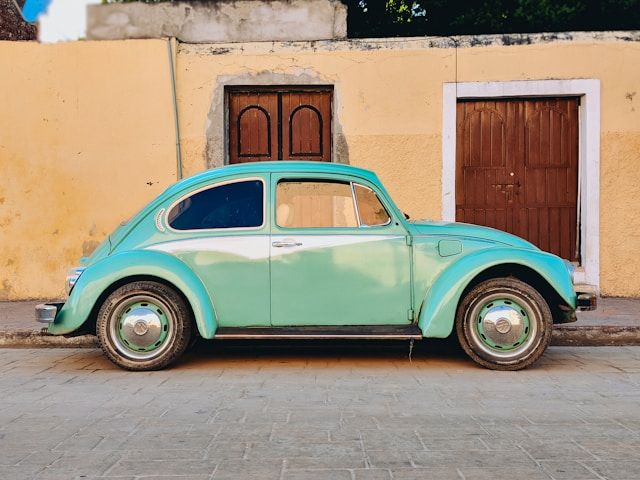

In [42]:
image

Use the `processor` to prepare the inputs for the model. The `processor` combines an image processor that prepares the image for the model by resizing and normalizing it, and a tokenizer that takes care of the text inputs.

In [43]:
candidate_labels = ["tree", "car", "bike", "cat"]
inputs = processor(images=image, text=candidate_labels, return_tensors="tf", padding=True)

In [45]:
inputs

{'input_ids': <tf.Tensor: shape=(4, 3), dtype=int32, numpy=
array([[49406,  2677, 49407],
       [49406,  1615, 49407],
       [49406,  3701, 49407],
       [49406,  2368, 49407]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=int32)>, 'pixel_values': <tf.Tensor: shape=(1, 3, 224, 224), dtype=float32, numpy=
array([[[[ 1.5799739 ,  1.5653756 ,  1.5653756 , ..., -1.6462783 ,
          -1.6900735 , -1.6754751 ],
         [ 1.5945723 ,  1.5799739 ,  1.5507771 , ..., -1.6608766 ,
          -1.6754751 , -1.6900735 ],
         [ 1.6091708 ,  1.5945723 ,  1.477785  , ..., -1.6316798 ,
          -1.500294  , -1.6462783 ],
         ...,
         [ 0.49969047,  0.4558952 ,  0.41209993, ...,  0.38290307,
           0.3537062 ,  0.3537062 ],
         [ 0.17852512, -0.06964822,  0.10553299, ...,  0.36830464,
           0.38290307,  0.38290307],
         [ 0.54348576,  0.48509204,  0.52888

Pass the inputs through the model, and post-process the results:

In [44]:
outputs = model(**inputs)

# Assuming that 'outputs' is a dictionary and 'logits_per_image' is a key that returns a batch of logits
logits = outputs['logits_per_image'][0]

# Compute softmax probabilities
probs = tf.nn.softmax(logits, axis=-1).numpy()

# Assuming that 'candidate_labels' is a list of labels
result = [
    {"score": float(score), "label": candidate_label}
    for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

[{'score': 0.998863935470581, 'label': 'car'},
 {'score': 0.0008396718767471611, 'label': 'bike'},
 {'score': 0.0002650553942658007, 'label': 'tree'},
 {'score': 3.1372637749882415e-05, 'label': 'cat'}]

See https://huggingface.co/docs/transformers/tasks/zero_shot_object_detection for more examples.

# 📘 BERT

### Try out [`BERT`](https://huggingface.co/docs/transformers/model_doc/bert)

Feel free to swap out the sentence below for one of your own. However, leave [MASK] in somewhere to allow BERT to predict the missing word:

In [46]:
unmasker = pipeline('fill-mask', model='bert-base-uncased', framework="tf", device=0)
unmasker("Artificial Intelligence [MASK] take over the world.")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[{'score': 0.31827324628829956,
  'token': 2064,
  'token_str': 'can',
  'sequence': 'artificial intelligence can take over the world.'},
 {'score': 0.182969868183136,
  'token': 2097,
  'token_str': 'will',
  'sequence': 'artificial intelligence will take over the world.'},
 {'score': 0.0561818853020668,
  'token': 2000,
  'token_str': 'to',
  'sequence': 'artificial intelligence to take over the world.'},
 {'score': 0.04529551416635513,
  'token': 2015,
  'token_str': '##s',
  'sequence': 'artificial intelligences take over the world.'},
 {'score': 0.04511474817991257,
  'token': 2052,
  'token_str': 'would',
  'sequence': 'artificial intelligence would take over the world.'}]

For chinese, we can use the model from [https://github.com/ckiplab/ckip-transformers](https://github.com/ckiplab/ckip-transformers):

In [51]:
unmasker = pipeline('fill-mask', model='ckiplab/bert-base-chinese', device=0)
unmasker("中[MASK]大學")

[{'score': 0.44112613797187805,
  'token': 1925,
  'token_str': '央',
  'sequence': '中 央 大 學'},
 {'score': 0.3117605447769165,
  'token': 2255,
  'token_str': '山',
  'sequence': '中 山 大 學'},
 {'score': 0.10464213043451309,
  'token': 3633,
  'token_str': '正',
  'sequence': '中 正 大 學'},
 {'score': 0.058359380811452866,
  'token': 5646,
  'token_str': '興',
  'sequence': '中 興 大 學'},
 {'score': 0.051102496683597565,
  'token': 1333,
  'token_str': '原',
  'sequence': '中 原 大 學'}]

See https://huggingface.co/tasks/fill-mask for more information!

## 🔍 Fintune Bert (Optional)

Text classification is a common NLP task that assigns a label or class to text. Some of the largest companies run text classification in production for a wide range of practical applications. One of the most popular forms of text classification is sentiment analysis.

This guide will show you how to:

1. Finetune [DistilBERT](https://huggingface.co/distilbert-base-uncased) on the [IMDb](https://huggingface.co/datasets/imdb) dataset to determine whether a movie review is positive or negative.
2. Use your finetuned model for inference.

### Load IMDb dataset

In [63]:
imdb = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Then take a look at an example:

In [64]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

There are two fields in this dataset:

- `text`: the movie review text.
- `label`: a value that is either `0` for a negative review or `1` for a positive review.

### Preprocess

The next step is to load a `DistilBERT` tokenizer to preprocess the `text` field:

In [65]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Create a preprocessing function to tokenize `text` and truncate sequences to be no longer than DistilBERT's maximum input length:

In [66]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

To apply the preprocessing function over the entire dataset, use Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) function. You can speed up `map` by setting `batched=True` to process multiple elements of the dataset at once:

In [67]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Now create a batch of examples using [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [68]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

### Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric). Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [69]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`:

In [70]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [71]:
batch_size = 16
num_epochs = 3
batches_per_epoch = len(tokenized_imdb["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

Then you can load DistilBERT with [TFAutoModelForSequenceClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.TFAutoModelForSequenceClassification) along with the number of expected labels, and the label mappings:

In [72]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [73]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_237 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Convert your datasets to the `tf.data.Dataset` format with [prepare_tf_dataset()](https://huggingface.co/docs/transformers/main/en/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset):

In [74]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_imdb["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_imdb["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer)

The last two things to setup before you start training is to compute the accuracy from the predictions, and provide a way to push your model to the Hub. Both are done by using [Keras callbacks](https://huggingface.co/docs/transformers/main/en/tasks/../main_classes/keras_callbacks). Pass your `compute_metrics` function to [KerasMetricCallback](https://huggingface.co/docs/transformers/main/en/main_classes/keras_callbacks#transformers.KerasMetricCallback).

In [75]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

callbacks = [metric_callback]

In [76]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3
1562/1562 [==============================] - 1076s 677ms/step - loss: 0.2574 - val_loss: 0.1866 - accuracy: 0.9280
Epoch 2/3
1562/1562 [==============================] - 1050s 672ms/step - loss: 0.1353 - val_loss: 0.1959 - accuracy: 0.9312
Epoch 3/3
1562/1562 [==============================] - 1049s 672ms/step - loss: 0.0669 - val_loss: 0.2240 - accuracy: 0.9311


### Inference

Great, now that you've finetuned a model, you can use it for inference! Grab some text you'd like to run inference on:

In [77]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."

Get the class with the highest probability, and use the model's `id2label` mapping to convert it to a text label:

In [78]:
inputs = tokenizer(text, return_tensors="tf")
logits = model(**inputs).logits
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'POSITIVE'

# 📘 GPT

## Generate text

Let's start by loading the 1.5-billion-parameter version of GPT-2 with a language modeling head.

To see how naive greedy search works for text generation. We'll use "Transformers are the" as the input prompt and run the decoding for eight timesteps. At each timestep, we pick out the model’s logits for the last token in the prompt and wrap them with a softmax to get a
probability distribution. We then pick the next token with the highest probability, add it to the input sequence, and run the process again. The following code does the job, and also stores the five most probable tokens at each timestep so we can visualize the alternatives:

In [52]:
# Select model and tokenizer
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForCausalLM.from_pretrained(model_name)
input_txt = "Transformers are the"

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [53]:
# @title Greedy search
n_steps = 8 #@param {type:"number"}
choices_per_step = 5 #@param {type:"number"}
# Select device
device = "GPU:0" if tf.config.list_physical_devices('GPU') else "CPU"

# Set device for the model
with tf.device(device):
    input_ids = tokenizer(input_txt, return_tensors="tf")["input_ids"]
    iterations = []

    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = tf.nn.softmax(next_token_logits, axis=-1)
        sorted_ids = tf.argsort(next_token_probs, direction='DESCENDING')

        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].numpy()
            token_choice = (
                f"{tokenizer.decode([token_id.numpy()])} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice

        input_ids = tf.concat([input_ids, tf.reshape(sorted_ids[0], (1, 1))], axis=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.54%),only (4.96%),best (4.66%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.95%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.36%),in (18.21%),of (11.71%),brand (6.09%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.39%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.40%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.27%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.88%),with (2.32%),today (1.75%)


> See https://huggingface.co/docs/transformers/generation_strategies

> In many cases, the architecture you want to use can be guessed from the name or the path of the pretrained model you are supplying to the `from_pretrained()` method. AutoClasses are here to do this job for you so that you automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary.

Implementing greedy search wasn't too hard, but we'll want to use the built-in `generate()` function from Transformers to explore more sophisticated decoding methods. To reproduce our simple example, let's make sure sampling is switched off (it's off by default, unless the specific configuration of the model you are loading the checkpoint from states otherwise) and specify the `max_new_tokens` for the number of newly generated tokens:

In [55]:
n_steps = 50
input_ids = tokenizer(input_txt, return_tensors="tf")["input_ids"]
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False) # do_sample: Whether or not to use sampling ; use greedy decoding otherwise.
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the most popular toy line in the world, and the Transformers are the most popular toy line in the world.

The Transformers are the most popular toy line in the world, and the Transformers are the most popular toy line in the world.




Instead of decoding the token with the highest probability at each step, **beam search** keeps track of the top-b most probable next tokens:

In [56]:
output = model.generate(input_ids, max_new_tokens=n_steps, num_beams=5, do_sample=False)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the most popular toy line in the world, and they've been around for over 30 years, so it's no surprise that there are a lot of people who love them. But there are also a lot of people who don't like them.




The simplest sampling method is to randomly sample from the probability distribution of the model's outputs over the full vocabulary at each timestep. By tuning `temperature` we can control the shape of the probability distribution when sampling. To see how we can use temperature to influence the generated text, let's sample with `temperature=2` by setting the temperature parameter in the `generate()` function:

In [57]:
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=True, temperature=2.0, top_k=0)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the lighter trozzo being dumped at about load sales land offences waiting land defendants Vol soap Oprah Console Driving stripe Cow in Mandarin Plug Gund GMilled Phill Tap accuses mum Buzziva pudding CH Snapdragon Glad ly duo June fridge Danny gr In Kot LawbaseAnd inhal reasons


There's always a trade-off between coherence (low temperature) and diversity (high temperature) that one has to tune to the use case at hand:

In [58]:
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=True, temperature=0.5, top_k=0)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the unsung heroes of the Transformers universe. They are the ones who, at times, lead the Autobots into battle, and sometimes the Decepticons. They are also the ones who, at times, have to save the day. They are the


The idea behind **top-k sampling** is to avoid the low-probability choices by only sampling from the `k` tokens with the highest probability. This puts a fixed cut on the long tail of the distribution and ensures that we only sample from likely choices

In [59]:
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=True, top_k=50)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the best.

Sigourney Weaver: If I was a little kid, I'd want to become a robot. You're trying to make your life as difficult as you can. That's what their message is — that anything they do in life


We can also try chinese using the following model:

In [60]:
# casual language model (GPT2)
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModelForCausalLM.from_pretrained('ckiplab/gpt2-base-chinese').to(device) # or other models above

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/421M [00:00<?, ?B/s]

In [61]:
input_txt = "中山大學是座落於西子灣的一間學校"
n_steps = 300
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [62]:
output = model.generate(input_ids, max_new_tokens=n_steps, num_beams=1, do_sample=True, top_k=50)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


========Generated Text==========
[CLS] 中 山 大 學 是 座 落 於 西 子 灣 的 一 間 學 校 [SEP] 校 舍 落 成 後 ， 該 校 即 為 名 譽 博 士 課 程 學 生 ， 學 生 於 2007 年 獲 得 國 家 重 點 實 驗 樓 [UNK] 國 家 重 點 實 驗 樓 [UNK] 之 建 築 與 重 大 工 程 獎 的 認 證 。 其 後 在 2007 年 獲 得 [UNK] 國 家 重 點 實 驗 樓 [UNK] 之 認 證 資 格 。 該 校 的 創 辦 人 以 色 列 國 防 軍 成 員 ， 曾 參 加 過 多 次 的 軍 事 演 習 、 與 海 軍 基 地 進 行 的 演 習 ， 但 遭 國 會 否 決 。 2008 年 8 月 30 日 ， 由 於 以 色 列 國 防 軍 不 能 通 過 國 家 重 點 實 驗 樓 的 認 證 ， 以 色 列 方 面 再 度 提 出 通 過 中 山 大 學 及 其 附 屬 醫 院 接 替 國 家 重 點 實 驗 樓 的 建 議 。 中 山 大 學 為 了 推 廣 重 點 實 驗 樓 是 一 間 工 業 設 計 的 ， 也 是 其 中 一 間 重 點 實 驗 樓 的 組 成 部 分 。 該 校 並 曾 經 多 次 派 員 致 函 日 本 防 衛 廳 請 求 國 會 同 意 國 防 部 在 中 山 大 學 校 園 工 程 中 設 計 的 工 作 內 容 。 為 了 推 廣 重 點 實 驗 樓 的 設 置 ， 中 山 大 學 將 其 列 為 國 家 重 點 實 驗 樓 一 部 分 。


# References

1.[https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

2.[https://github.com/fchollet/deep-learning-with-python-notebooks_](https://github.com/fchollet/deep-learning-with-python-notebooks_)

3.[https://huggingface.co/docs/transformers/v4.29.1/en/tasks/sequence_classification](https://huggingface.co/docs/transformers/v4.29.1/en/tasks/sequence_classification)

4.[https://huggingface.co/docs/transformers/tasks/zero_shot_image_classification](https://huggingface.co/docs/transformers/tasks/zero_shot_image_classification)

